## CS 222 Problem Set 3 Code

#### Libraries

In [139]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)

#### Problem 3

(array([  8.,  18.,  35.,  55., 100., 162., 214., 247., 131.,  30.]),
 array([ 2026. ,  3200.3,  4374.6,  5548.9,  6723.2,  7897.5,  9071.8,
        10246.1, 11420.4, 12594.7, 13769. ]),
 <a list of 10 Patch objects>)

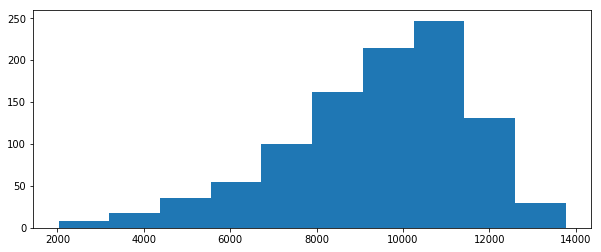

In [198]:
def cuckoo(table, hash_table, value, counter):
    '''We are writing value to the table by looking up its two 
       locations in hash_table.'''
    if counter >= 100: return 100 # break recursion
    
    # Check if value has already been hashed
    if value not in hash_table: 
        h1 = random.randint(0,32767)
        h2 = random.randint(0,32767)
        hash_table[value] = (h1, h2)

    # Extract from hash table
    h1, h2 = hash_table[value]

    # Check if in table
    if table[h1] == 0: 
        table[h1] = value
        return counter
    elif table[h2] == 0: 
        table[h2] = value
        return counter
    else:
        # If both are full, kick one out
        h = h1 if random.random() < 0.5 else h2
        new_value = table[h]
        table[h] = value
        return cuckoo(table, hash_table, new_value, counter + 1)

# Run until we cannot add an element
def experiment():
    table = [0] * 32768
    
    # Loop
    i=0
    hash_table = {}
    while(True):
        i+=1
        
        # Generate value to put in rable
        value = random.randint(0,1000000)
        
        # Place in table
        if cuckoo(table, hash_table, value, 0) >= 100:
            break
            
    return table

# Run 1000 experiments
num_filled_entries = []
for _ in range(1000):
    num_filled_entries.append(sum(1 for x in experiment() if x != 0))

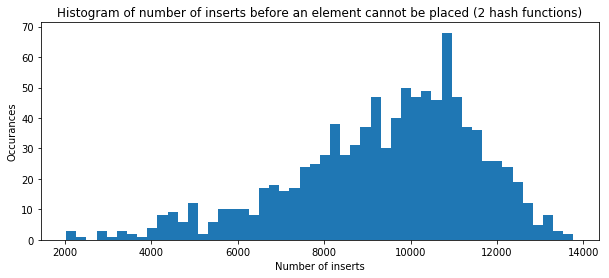

In [299]:
plt.hist(num_filled_entries, bins=50)
plt.title('Histogram of number of inserts before an element cannot be placed (2 hash functions)')
plt.ylabel('Occurances')
plt.xlabel('Number of inserts')
plt.show()

In [297]:
def cuckoo3(table, hash_table, value, counter):
    '''We are writing value to the table by looking up its two 
       locations in hash_table.'''
    if counter >= 100: return 100 # break recursion
    
    # Check if value has already been hashed
    if value not in hash_table: 
        h1 = random.randint(0,32767)
        h2 = random.randint(0,32767)
        h3 = random.randint(0,32767)
        hash_table[value] = (h1, h2, h3)

    # Extract from hash table
    h1, h2, h3 = hash_table[value]

    # Check if in table
    if table[h1] == 0: 
        table[h1] = value
        return counter
    elif table[h2] == 0: 
        table[h2] = value
        return counter
    elif table[h3] == 0: 
        table[h3] = value
        return counter
    else:
        # If both are full, kick one out
        r = random.random()
        h = h1 if r < 0.33 else (h2 if r < 0.66 else h3)
        new_value = table[h]
        table[h] = value
        return cuckoo3(table, hash_table, new_value, counter + 1)

# Run until we cannot add an element
def experiment():
    table = [0] * 32768
    
    # Loop
    i=0
    hash_table = {}
    while(True):
        i+=1
        
        # Generate value to put in rable
        value = random.randint(0,1000000)
        
        # Place in table
        if cuckoo3(table, hash_table, value, 0) >= 100:
            break
            
    return table

# Run 1000 experiments
num_filled_entries_3 = []
for _ in range(1000):
    num_filled_entries_3.append(sum(1 for x in experiment() if x != 0))

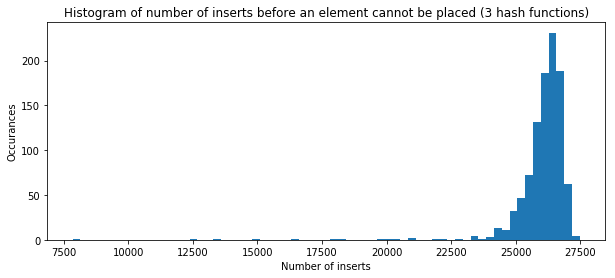

In [301]:
plt.hist(num_filled_entries_3, bins=65)
plt.title('Histogram of number of inserts before an element cannot be placed (3 hash functions)')
plt.ylabel('Occurances')
plt.xlabel('Number of inserts')
plt.show()

In [295]:
# Average
sum(num_filled_entries) / len(num_filled_entries)

9413.436

In [296]:
# Average 
sum(num_filled_entries_3) / len(num_filled_entries_3)

26025.355

In [307]:
# More experiments!
table = [0] * 32768

# Loop
i=0
hash_table = {}
xs = []
while(True):
    i+=1

    # Generate value to put in rable
    value = random.randint(0,1000000)

    # Place in table
    x = cuckoo3(table, hash_table, value, 0)
    xs.append(x)
    if x >= 100:
        break

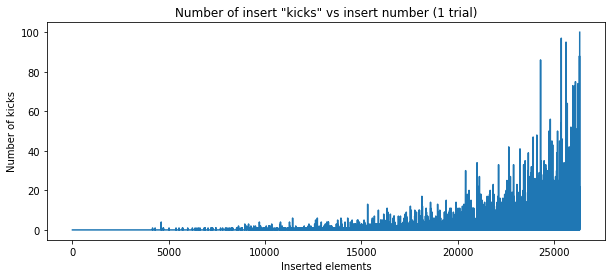

In [310]:
plt.title('Number of insert "kicks" vs insert number (1 trial)')
plt.ylabel('Number of kicks')
plt.xlabel('Inserted elements')
plt.plot(xs)

#### Problem 4 

In [278]:
def get_stream():
    stream = []
    
    # Add cold elements
    for i in range(1,10): 
        for k in range(1000*(i-1)+1, 1000*i+1):
            for _ in range(i):
                stream.append(k)

    # Add hot elements
    for i in range(1,101): 
        k = 9000 + i
        for _ in range(i*i):
            stream.append(k)
            
    print('Stream is length', len(stream))
    return stream 

def perform_cm_sketch(stream, conservative_update):
    
    hash_maps = [{}, {}, {}, {}] # will store map from i --> hash_loc
    hash_tables = [[0]*500, [0]*500, [0]*500, [0]*500] # will store counter

    # Generate hashes
    for i in set(stream):
        for j in range(4):
            h = random.randint(1,499)
            hash_maps[j][i] = h

    # Add items 
    for i in stream:

        # Extract hashes
        hs = [hash_maps[j][i] for j in range(4)]
        min_counter = min(hash_tables[j][hs[j]] for j in range(4))

        # Increment counter
        for j in range(4):
            if not conservative_update or hash_tables[j][hs[j]] == min_counter:
                hash_tables[j][hs[j]] += 1
    
    return hash_maps, hash_tables

def get_statistics(stream, hash_maps, hash_tables):
    # Check how many elements may be responsible for >= 1% of total load
    n_elems = 0
    for i in set(stream):
        hs = [hash_maps[j][i] for j in range(4)]
        min_counter = min(hash_tables[j][hs[j]] for j in range(4))
        if min_counter > len(stream) * 0.01:
            n_elems += 1
    # print('Above 1% estimate: ', n_elems)

    # Check the value of 9100
    hs = [hash_maps[j][9100] for j in range(4)]
    est_9100 = min(hash_tables[j][hs[j]] for j in range(4))
    # print('9100 estimate:     ', min_counter)
    
    return n_elems, est_9100

In [289]:
# Parameters
conservative = True
stream = get_stream()
random.shuffle(stream)

# Experiment
N = 100
n_elems_total, est_9100_total = 0, 0
for i in range(N):
    hm, ht = perform_cm_sketch(stream, conservative)
    n_elems, est_9100 = get_statistics(stream, hm, ht)
    n_elems_total += n_elems
    est_9100_total += est_9100
print(n_elems_total / N)
print(est_9100_total /  N)

Stream is length 383350
39.33
10000.0


In [283]:
correct_n_elems = sum(1 for i in range(100) if i*i >= len(stream) * 0.01)
print('Exact number of elements above 1%:', correct_n_elems)

Exact number of elements above 1%: 38


#### Problem 5

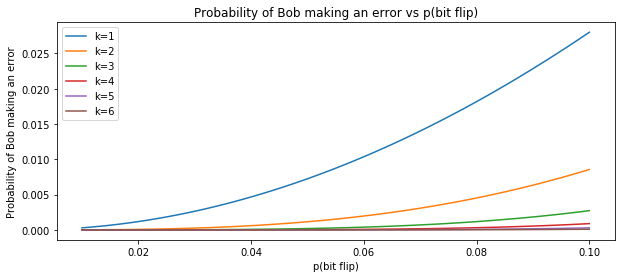

In [141]:
# Error function
from scipy.special import binom
def p_error(k, p):
    return sum(binom(2*k+1, i) * (p**i * (1-p)**(2*k+1-i)) for i in range(k+1,2*(k+1))) 

# Calculate errors for different values of k
x = np.arange(0.01,0.1,0.001)
ys = np.stack([p_error(k, x) for k in range(1,7)], axis=1)

# Plot
plt.title('Probability of Bob making an error vs p(bit flip)')
plt.ylabel('Probability of Bob making an error')
plt.xlabel('p(bit flip)')
plt.plot(x,ys)
plt.legend(['k='+str(k) for k in range(1,7)])

#### Problem 6 

In [42]:
def check(a0, a1, a2, a3):
    '''Returns number of successful check given polynomial coefficients'''
    total = 0
    total += ((a0 + a1 + a2 + a3 ) % 29 == 15)
    total += ((a0 + a1*2**1 + a2*2**2 + a3*2**3) % 29 == 13)
    total += ((a0 + a1*3**1 + a2*3**2 + a3*3**3) % 29 == 33)
    total += ((a0 + a1*4**1 + a2*4**2 + a3*4**3) % 29 == 24)
    total += ((a0 + a1*5**1 + a2*5**2 + a3*5**3) % 29 ==  1)
    total += ((a0 + a1*6**1 + a2*6**2 + a3*6**3) % 29 == 22)
    return total

# Let's try brute force
from itertools import product
for a0, a1, a2, a3 in product(range(29),range(29),range(29),range(29)):
    if check(a0, a1, a2, a3) >= 5:
        print(a0, a1, a2, a3)
        alphabet = 'abcdefghijklmnopqrstuvwxyz'
        print(''.join([alphabet[x-1] for x in [a0, a1, a2, a3]]))

17 21 9 26
quiz
